In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

## Create test dataset

In [3]:
dataset_length = 100
D = 2
X = np.random.randn(dataset_length,D)*0.1
X[0:dataset_length/2,0] += 0.2
X[0:dataset_length/2,1] += 1
Y = np.ones(dataset_length)
Y[0:dataset_length/2] *= 0

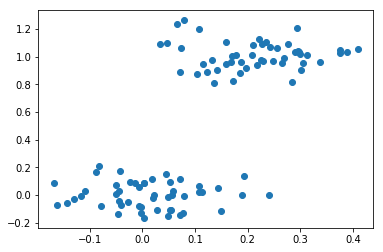

In [4]:
plt.plot(X[:,0],X[:,1],"o")

## Create a Decision Tree trained on this dataset

In [5]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

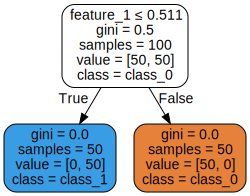

In [6]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["feature_"+str(i) for i in range(D)],  
                         class_names=["class_0", "class_1"],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

### Modify the threshold of the tree
+ The first threshold is splitting the dataset along feature_1 at location 0.51
+ Let us classify the point [0.1, 0.5]

In [7]:
clf.tree_.threshold

array([ 0.51118094, -2.        , -2.        ])

In [8]:
clf.predict(np.asarray([[0.1,0.5]]))

array([ 1.])

In [9]:
clf.decision_path(np.asarray([[0.1,0.5]])).toarray()

array([[1, 1, 0]])

+ Let us modify the threshold and put it equal to 0
+ Let us classify the same point

In [10]:
clf.tree_.threshold[0] = 0

In [11]:
clf.predict(np.asarray([[0.1,0.5]]))

array([ 0.])

In [12]:
clf.decision_path(np.asarray([[0.1,0.5]])).toarray()

array([[1, 0, 1]])

## Conclusion
Modifying the threshold outside the tree seems to work well :)

## Let us access to important elements from the Decision Tree
the object tree_ keeps the information describing the tree in lists, such that information contained at index $i$ corresponds to the node $i$ of the tree. The root of the tree is labeled 0. we can get the children's indexes using `children_left` or `children_right` arrays

In [55]:
clf.tree_.children_left

array([ 1, -1, -1])

In [56]:
clf.tree_.children_right

array([ 2, -1, -1])

In this case, a leaf is simply a node $\nu_i$ such that `clf.tree_.children_right[i] == -1` and `clf.tree_.children_left[i] ==1`

+ The feature to split on is stored in list `feature`
+ The thresholds in list `threshold`
+ The number of training samples reaching the node are stored in `n_node_samples` 
+ The `decision_path` of the target dataset will be helpfull to re-attribute the instances
+ The `value` list provides the number of elements from each class in the current node

In [15]:
path = clf.decision_path(X[0:3,:])

In [16]:
path.toarray()

array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [34]:
def prune(decisiontree, min_samples_leaf = 1):
    if decisiontree.min_samples_leaf >= min_samples_leaf:
        raise Exception('Tree already more pruned')
    else:
        decisiontree.min_samples_leaf = min_samples_leaf
        tree = decisiontree.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree.children_left[i]=-1
                tree.children_right[i]=-1